# Training a Neural Network

In this homework, our objective is to implement a simple neural network from scratch, in particular, error backpropagation and the gradient descent optimization procedure. We first import some useful libraries.

In [2]:
import numpy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

na = numpy.newaxis
numpy.random.seed(0)

We consider a two-dimensional moon dataset on which to train the network. We also create a grid dataset which we will use to visualize the decision function in two dimensions. We denote our two inputs as $x_1$ and $x_2$ and use the suffix `d` and `g` to designate the actual dataset and the grid dataset.

In [3]:
# Create a moon dataset on which to train the neural network
import sklearn, sklearn.datasets

Xd, Td = sklearn.datasets.make_moons(n_samples=100)
Xd = Xd * 2 - 1
Td = Td * 2 - 1
X1d = Xd[:, 0]
X2d = Xd[:, 1]

# Creates a grid dataset on which to inspect the decision function
l = numpy.linspace(-4, 4, 100)
X1g, X2g = numpy.meshgrid(l, l)

The moon dataset is plotted below along with some dummy decision function $x_1+x_2=0$.

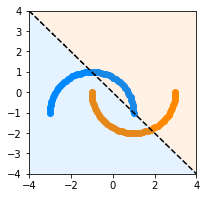

In [4]:
def plot(Yg, title=None):
    plt.figure(figsize=(3, 3))
    plt.scatter(*Xd[Td == -1].T, color='#0088FF')
    plt.scatter(*Xd[Td == 1].T, color='#FF8800')
    plt.contour(X1g, X2g, Yg, levels=[0], colors='black', linestyles='dashed')
    plt.contourf(X1g, X2g, Yg, levels=[-100, 0, 100], colors=['#0088FF', '#FF8800'], alpha=0.1)
    if title is not None: plt.title(title)
    plt.show()


plot(X1g + X2g)  # plot the dummy decision function

## Part 1: Implementing Error Backpropagation (30 P)

We would like to implement the neural network with the equations:
\begin{align*}
\forall_{j=1}^{25}:~ z_j &= x_1 w_{1j} + x_2 w_{2j} + b_j\\
\forall_{j=1}^{25}:~a_j &= \max(0,z_j)\\
y &= \sum_{j=1}^{25} a_j v_j
\end{align*}
where $x_1,x_2$ are the two input variables and $y$ is the output of the network. The parameters of the neural network are initialized randomly using the normal distributions $w_{ij} \sim \mathcal{N}(\mu=0,\sigma^2=1/2)$, $b_{j} \sim \mathcal{N}(\mu=0,\sigma^2=1)$, $v_{j} \sim \mathcal{N}(\mu=0,\sigma^2=1/25)$. The following code initializes the parameters of the network and implements the forward pass defined above. The neural network is composed of 50 neurons.

In [37]:
import numpy

NH = 50

W = numpy.random.normal(0, 1 / 2.0 ** .5, [2, NH])
B = numpy.random.normal(0, 1, [NH])
V = numpy.random.normal(0, 1 / NH ** .5, [NH])


def forward(X1, X2):
    X = numpy.array([X1.flatten(), X2.flatten()]).T  # Convert meshgrid into dataset
    Z = X.dot(W) + B
    A = numpy.maximum(0, Z)
    Y = A.dot(V)
    return Y.reshape(X1.shape) # Reshape output into meshgrid

We now consider the task of training the neural network to classify the data. For this, we define the error function:
$$
\mathcal{E}(\theta) = \sum_{k=1}^N \max(0,-y^{(k)} t^{(k)})
$$
where $N$ is the number of data points, $y$ is the output of the network and $t$ is the label.

**Task:**

 * **Complete the function below so that it returns the gradient of the error w.r.t. the parameters of the model.**

In [38]:
np = numpy
def backprop(X1, X2, T):
    X = numpy.array([X1.flatten(), X2.flatten()]).T

    # Compute activations
    Z = X.dot(W) + B
    A = numpy.maximum(0, Z)
    Y = A.dot(V)

    # Compute backward pass
    DY = (-Y*T>0)*(-T) # de/dy

    # de/dz = de/dy * v_j * activation(j)
    dz = np.zeros(Z.shape)
    for i, v in enumerate(V):
        neuron_output = v * (A[:,i] > 0)
        # gradient dy/dz is non zero only when a_j for corresponding neuron "fires"
        _dz = DY * neuron_output
        dz[:,i] = _dz
    # de/dv = de/dy * dy/dv
    dv = np.zeros(V.shape)
    for i, a in enumerate(A.T):
        # dy/dv is non zero only when a_j on corresponding neuron "fires"
        _dv = (DY * a).mean() # mean with over dy
        dv[i] = _dv
    # de/dw1 = dy/dz * dz/dw1 where dz/dw1 = x1
    dw1 = (X1 * dz.T).mean(axis=1)
    dw2 = (X2 * dz.T).mean(axis=1)
    dw = np.array([dw1, dw2])
    db = dz.mean(axis=0)
    return dw, db, dv

## Exercise 2: Training with Gradient Descent (20 P)

We would like to use error backpropagation to optimize the parameters of the neural network. The code below optimizes the network for $128$ iterations and at some chosen iterations plots the decision function along with the current error.

**Task:**
 * **Complete the procedure above to perform at each iteration a step along the gradient in the parameter space. A good choice of learning rate is $\eta=0.1$.**

/var/folders/vv/f22t8y7d1l96ynv9mzgy0j5w0000gn/T/ipykernel_61861/1411622521.py:5: UserWarning: No contour levels were found within the data range.
  plt.contour(X1g, X2g, Yg, levels=[0], colors='black', linestyles='dashed')


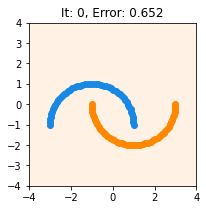

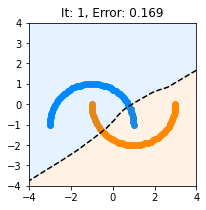

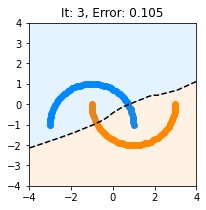

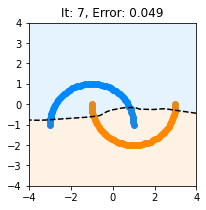

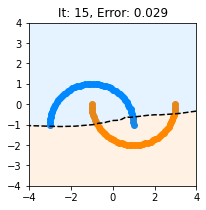

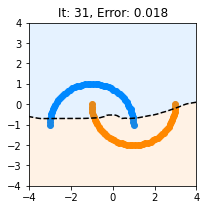

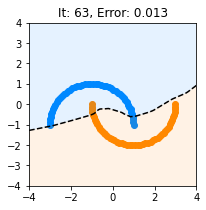

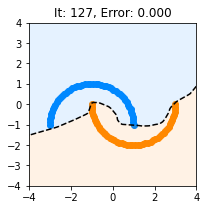

In [39]:
n = 0.1
dw, db, dv = 0, 0, 0
for i in range(128):
    dw, db, dv = backprop(X1d, X2d, Td)
    B -= n * db
    W -= n * dw
    V -= n * dv
    if i in [0, 1, 3, 7, 15, 31, 63, 127]:
        Yg = forward(X1g, X2g)
        Yd = forward(X1d, X2d)
        Ed = numpy.maximum(0, -Yd * Td).mean()
        plot(Yg, title="It: %d, Error: %.3f" % (i, Ed))